# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [86]:
rand = int(np.random.randint(100))

In [3]:
data_num = df
target_tag = 'SiteEUI(kBtu/sf)'
target = data_num[target_tag]
label = ['TotalGHGEmissions', 'ENERGYSTARScore','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity']
sqf = data_num['PropertyGFABuilding(s)']
data_num = data_num.drop(labels = [target_tag, 'TotalGHGEmissions', 'ENERGYSTARScore','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity'], axis = 1)

col_name_lib = {}
col_name = data_num.columns
for i,v in enumerate(col_name):
    col_name_lib[f'{i}'] = v


In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 522 entries, BuildingType_Campus to ThirdLargestPropertyUseTypeGFA
dtypes: float64(522)
memory usage: 6.5 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [87]:
#first let's split

xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, test_size = 0.2, random_state = rand)

df_res = xtest
df_res_train = xtrain
#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

In [88]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [89]:
def true_pred_plot(y_train,pred_train, y_test, pred_test, figname):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    y_train= np.array(y_train).reshape(-1,1)
    pred_train = np.array(pred_train).reshape(-1,1)
    y_test = np.array(y_test).reshape(-1,1)
    pred_test = np.array(pred_test).reshape(-1,1)
    
    
    
    y_train = y_train*sqftrain
    pred_train = pred_train*sqftrain
    
    line_reg_train = line_reg.fit(pred_train,y_train)
    r2_train = line_reg_train.score(pred_train,y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(y_train))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), y_train.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(y_train.min(),y_train.max())
    ax[0].set_ylim(pred_train.min(),pred_train.max())
    ax[0].set_title('On train values')

    y_test = y_test*sqftest
    pred_test = pred_test*sqftest
    
    line_reg_test  = line_reg.fit(pred_test,y_test)
    r2_test =  line_reg_test.score(pred_test,y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(y_test))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(y_test.min(),y_test.max())
    ax[1].set_ylim(pred_test.min(),pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.savefig(figname, bbox_inches = 'tight')
    plt.clf()

Do you want to launch ? [y/n] y


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


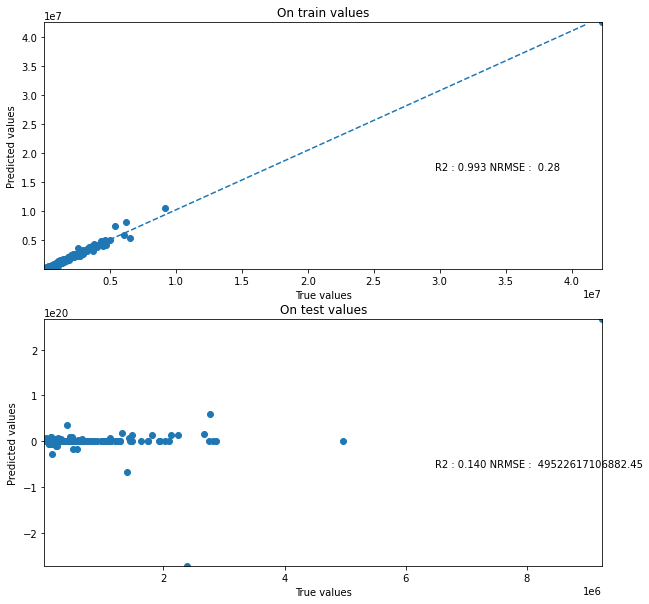

<Figure size 432x288 with 0 Axes>

In [90]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    line_reg_m = linear_model.LinearRegression()

    model_lr = line_reg_m.fit(xtrain,ytrain)


    true_pred_plot(ytrain, model_lr.predict(xtrain), ytest, model_lr.predict(xtest),'line_reg_ery.png')

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 10}
GridCV results : 
r2 = 0.153 (+/- 0.122) for {'n_neighbors': 2}
r2 = 0.228 (+/- 0.064) for {'n_neighbors': 3}
r2 = 0.252 (+/- 0.052) for {'n_neighbors': 4}
r2 = 0.263 (+/- 0.026) for {'n_neighbors': 5}
r2 = 0.264 (+/- 0.027) for {'n_neighbors': 6}
r2 = 0.270 (+/- 0.037) for {'n_neighbors': 7}
r2 = 0.269 (+/- 0.041) for {'n_neighbors': 8}
r2 = 0.270 (+/- 0.053) for {'n_neighbors': 9}
r2 = 0.274 (+/- 0.050) for {'n_neighbors': 10}
r2 = 0.274 (+/- 0.049) for {'n_neighbors': 11}
r2 = 0.271 (+/- 0.045) for {'n_neighbors': 12}
r2 = 0.270 (+/- 0.042) for {'n_neighbors': 13}
r2 = 0.271 (+/- 0.046) for {'n_neighbors': 14}
r2 = 0.268 (+/- 0.042) for {'n_neighbors': 15}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


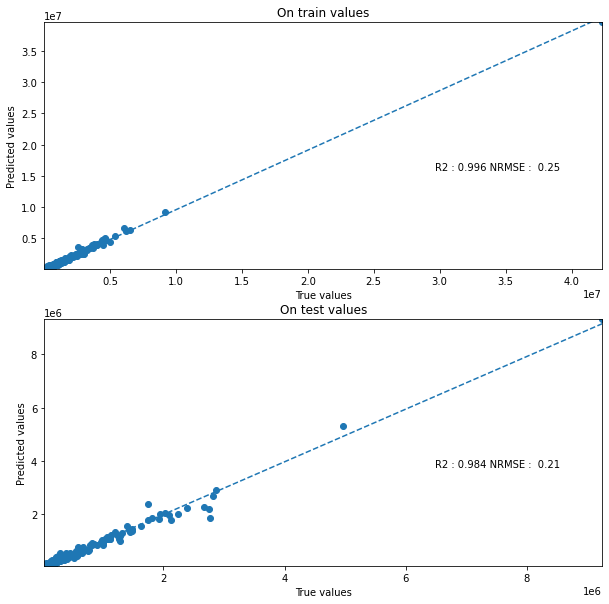

<Figure size 432x288 with 0 Axes>

In [91]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))
    
model_kn = KNeighborsRegressor(n_neighbors = reg.best_params_['n_neighbors']).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_kn.predict(xtrain), ytest, model_kn.predict(xtest),'knn_ergy.png')

Do you want to launch ? [y/n] y


Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best params on training set : {'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


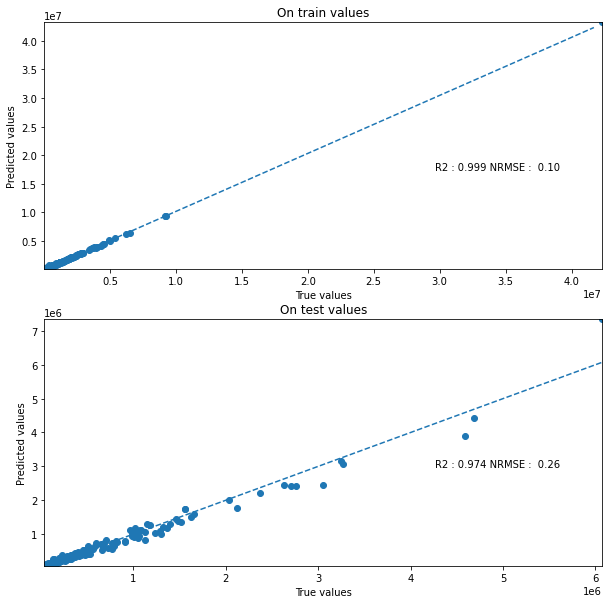

<Figure size 432x288 with 0 Axes>

In [16]:
x = input('Do you want to launch ? [y/n]')
if x == 'y':

    #let's try with a svr
    C_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'rbf', 'sigmoid', 'poly']
    degrees = [2,3,4]
    gamma_range  = np.logspace(-2, 1, 10)
    #gamma_range = np.logspace(-2, 1, 10)
    #'gamma' : gamma_range
    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

    score = 'neg_mean_squared_error'

    svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

    svr_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(svr_cv.best_params_))
bkernel = svr_cv.best_params_['kernel']
bgamma = svr_cv.best_params_['gamma']
bdegree = svr_cv.best_params_['degree']
    
svr = svm.SVR(kernel=bkernel, C=1.0, gamma = bgamma, degree = bdegree)
model_svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model_svr.predict(xtrain), ytest, model_svr.predict(xtest),'svr_ergy.png')

Do you want to launch ? [y/n] y


Fitting 3 folds for each of 360 candidates, totalling 1080 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.33433e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.03775e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=7.90372e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.10294e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.p

Best params on training set : {'alpha': 5.0, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


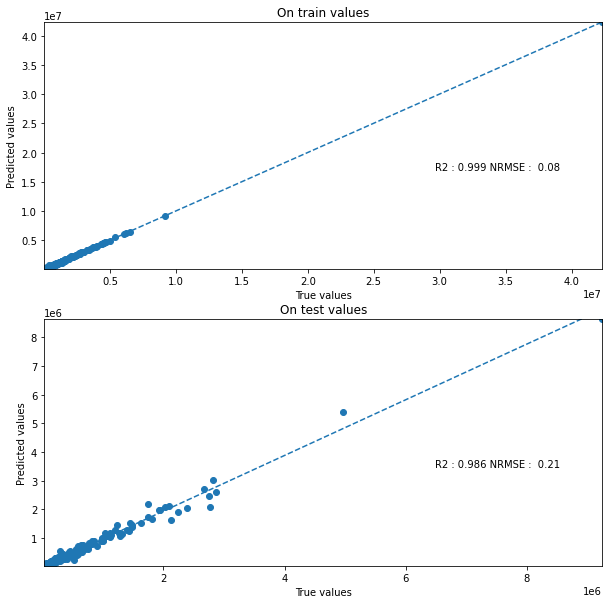

<Figure size 432x288 with 0 Axes>

In [92]:
from sklearn import kernel_ridge
#let's try with a ridge regression

x = input('Do you want to launch ? [y/n]')
if x == 'y':
    alpha_range = [1.0, 5.0, 10.0, 100.0]
    kernels = ['linear', 'poly', 'rbf']
    degrees = [3,4,5]
    gamma_range  = np.logspace(-2, 1, 10)


    param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
    score = 'neg_mean_absolute_percentage_error'

    kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

    kernel_ridge_cv.fit(xtrain, ytrain)

    print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))
    
bkernel = kernel_ridge_cv.best_params_['kernel']
bgamma = kernel_ridge_cv.best_params_['gamma']
bdegree = kernel_ridge_cv.best_params_['degree']
balpha = kernel_ridge_cv.best_params_['alpha']

model = kernel_ridge.KernelRidge(alpha = balpha, kernel = bkernel, degree = bdegree, gamma = bgamma)
model_krr = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model_krr.predict(xtrain), ytest, model_krr.predict(xtest),'krr_ergy.png')

## Neural network

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
#test with a single perceptron
model1 = keras.Sequential()
model1.add(keras.Input(shape = xtrain.shape[1]))
model1.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1.summary()

history1 = model1.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 523       
                                                                 
Total params: 523
Trainable params: 523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 2s 902us/step - loss: 116.6052 - root_mean_squared_error: 8.3470
Epoch 2/50
1304/1304 [==============================] - 1s 895us/step - loss: 90.6076 - root_mean_squared_error: 7.4136
Epoch 3/50
1304/1304 [==============================] - 1s 848us/step - loss: 79.9802 - root_mean_squared_error: 6.7977
Epoch 4/50
1304/1304 [==============================] - 1s 869us/step - loss: 71.6908 - root_mean_squared_error: 6.2653
Epoch 5/50
1304/1304 [==============================] - 1s 899us/step - loss: 64.1349 - root_mean_squared

11/11 [==============================] - 0s 800us/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


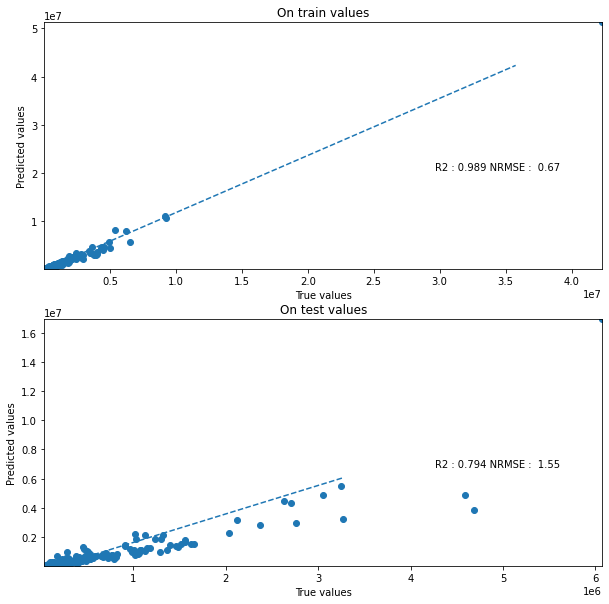

<Figure size 432x288 with 0 Axes>

In [21]:
true_pred_plot(ytrain, np.array(model1.predict(xtrain)).reshape(-1,1), ytest, np.array(model1.predict(xtest)).reshape(-1,1),'perce_ergy.png')

In [ ]:
model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="selu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="selu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

In [ ]:
true_pred_plot(ytrain, model2.predict(xtrain), ytest, model2.predict(xtest))

In [23]:
#now with a multi layer network

model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="selu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(383, activation="selu", name="layer2a"),
        layers.Dense(287, activation="selu", name="layer2"),
        layers.Dense(82, activation="selu", name="layer3"),
        layers.Dense(20, activation="selu", name="layer4"),
        layers.Dense(1, activation = 'linear', name="layer6"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 522)               273006    
                                                                 
 layer2a (Dense)             (None, 383)               200309    
                                                                 
 layer2 (Dense)              (None, 287)               110208    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer6 (Dense)              (None, 1)                 21        
                                                                 
Total params: 608,820
Trainable params: 608,820
Non-tr

11/11 [==============================] - 0s 2ms/step


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


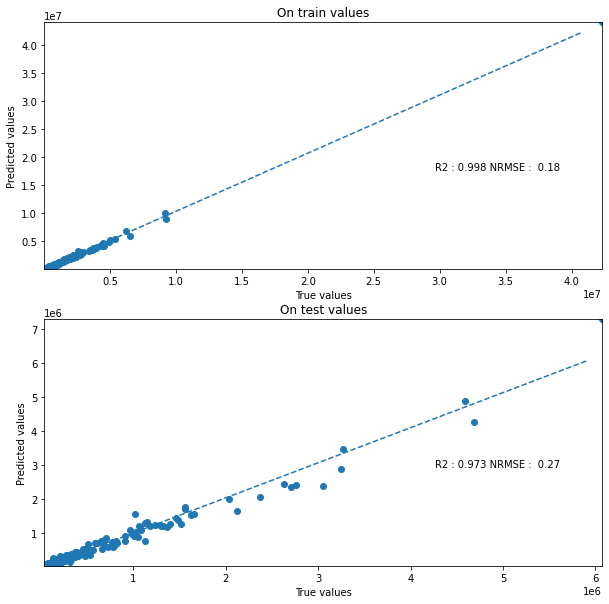

<Figure size 432x288 with 0 Axes>

In [24]:
true_pred_plot(ytrain, model3.predict(xtrain), ytest, model3.predict(xtest), 'model3_ergy.png')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params on training set : {'n_estimators': 350}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

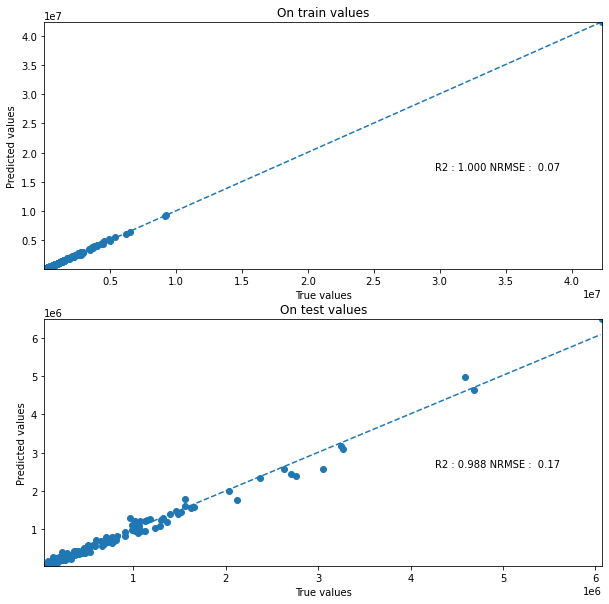

<Figure size 432x288 with 0 Axes>

In [25]:
from sklearn.ensemble import RandomForestRegressor

n_grid = {'n_estimators' : list(np.arange(50,550,50))}
score = 'r2'

rfr_grid = GridSearchCV(RandomForestRegressor(), n_grid, cv =3, scoring = score, verbose = 1)

rfr_grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(rfr_grid.best_params_))

    
model_rfr = RandomForestRegressor(n_estimators=rfr_grid.best_params_['n_estimators'], verbose = 1).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_rfr.predict(xtrain), ytest, model_rfr.predict(xtest),'rfr_ergy.png')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params on training set : {'n_estimators': 350}


E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
E:\Data_Science\Anaconda\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


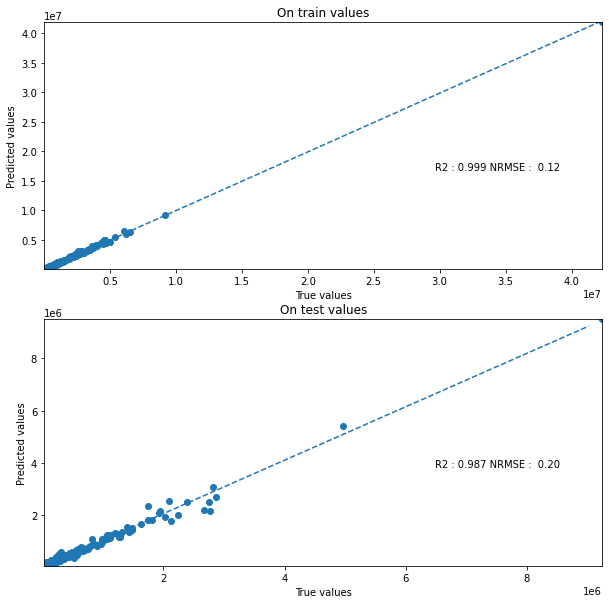

<Figure size 432x288 with 0 Axes>

In [119]:
from sklearn.ensemble import GradientBoostingRegressor

n_grid = {'n_estimators' : list(np.arange(50,550,50))}
score = 'r2'

xgb_grid = GridSearchCV(GradientBoostingRegressor(), n_grid, cv =3, scoring = score, verbose = 1)

xgb_grid.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(xgb_grid.best_params_))

    
model_xgb = GradientBoostingRegressor(n_estimators=xgb_grid.best_params_['n_estimators']).fit(xtrain, ytrain)

true_pred_plot(ytrain, model_xgb.predict(xtrain), ytest, model_xgb.predict(xtest),'xgb_ergy.png')

In [27]:
def r2(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = pred*sqftest
    y = y*sqftest
    
    line_reg_test  = line_reg.fit(pred,y)
    r2_value =  line_reg_test.score(pred,y)
    return r2_value

def rmse(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = pred*sqftest
    y = y*sqftest
    
    rmse_value = np.sqrt(metrics.mean_squared_error(y,pred))
    return rmse_value

def nrmse(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = pred*sqftest
    y = y*sqftest
    
    nrmse_value = (np.sqrt(metrics.mean_squared_error(y,pred))/np.mean(y))
    return nrmse_value
                   
def mae(pred,y):
    pred = np.array(pred).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    
    pred = pred*sqftest
    y = y*sqftest
    
    mae_value = metrics.mean_absolute_error(y,pred)
    return mae_value
            

11/11 [==============================] - 0s 2ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


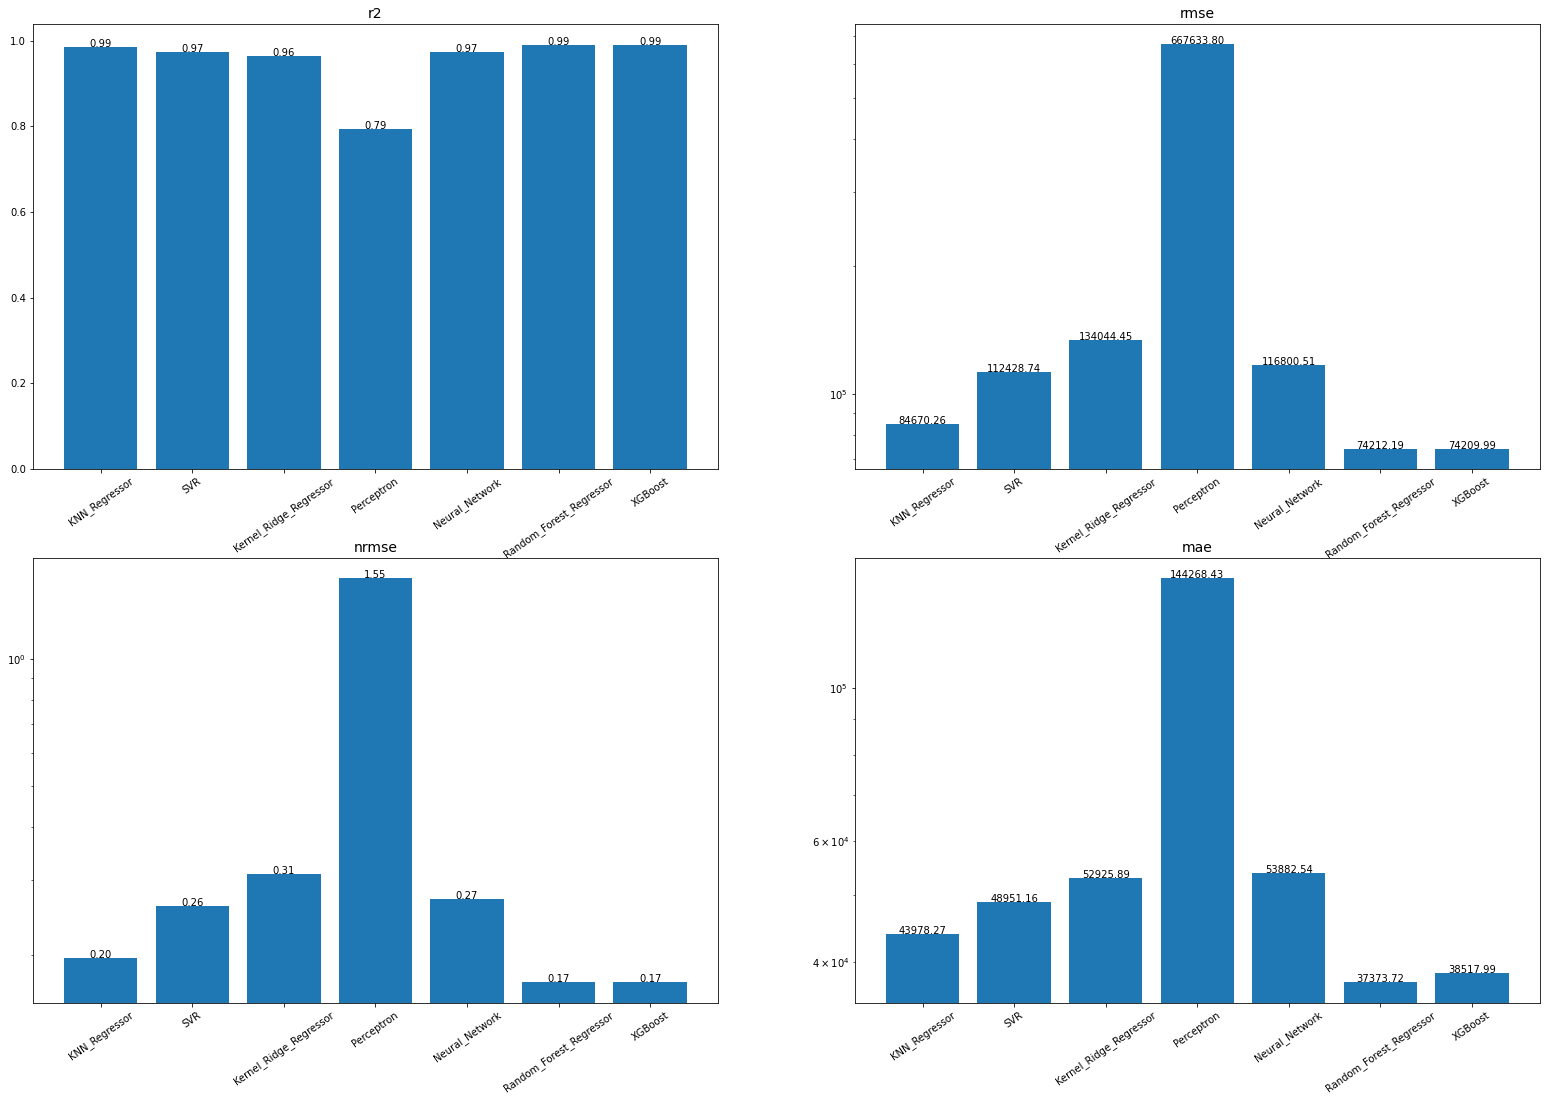

In [45]:
metrics_all = {}

models = [model_kn,svr,model_krr,model1,model3,model_rfr,model_xgb]
r2l=[]
rmsel=[]
nrmsel=[]
mael=[]

for i in models:
    r2l.append(r2(i.predict(xtest),ytest))
    rmsel.append(rmse(i.predict(xtest), ytest))
    nrmsel.append(nrmse(i.predict(xtest), ytest))
    mael.append(mae(i.predict(xtest), ytest))
    
metrics_all['r2'] = r2l
metrics_all['rmse'] = rmsel
metrics_all['nrmse'] = nrmsel
metrics_all['mae'] = mael

model_names = ['KNN_Regressor', 'SVR', 'Kernel_Ridge_Regressor','Perceptron','Neural_Network', 'Random_Forest_Regressor', 'XGBoost']
df_metrics = pd.DataFrame(metrics_all, index = model_names)

fig = plt.figure(figsize=(27, 18))
for i in range(df_metrics.shape[1]):
    ax = fig.add_subplot(2,2, (i+1))
    b = ax.bar(x=df_metrics.index,height = df_metrics.iloc[:, i])
    for y,v in enumerate(df_metrics.iloc[:, i]):
        ax.text(y,v, '%.2f'%v, ha = 'center')
    ax.set_title(df_metrics.columns[i], fontsize=14)
    ax.tick_params(axis='x', labelrotation = 35)
    if i != 0:
        ax.set_yscale('log')
plt.savefig('recap_ergy.png', bbox_inches = 'tight')

290
ThirdLargestPropertyUseTypeGFA                       0.229350
LargestPropertyUseType_Non-Refrigerated Warehouse    0.098108
PropertyGFABuilding(s)                               0.096316
LargestPropertyUseType_Supermarket/Grocery Store     0.067597
SecondLargestPropertyUseTypeGFA                      0.054626
LargestPropertyUseType_Self-Storage Facility         0.052480
LargestPropertyUseType_Distribution Center           0.022619
PrimaryPropertyType_Other                            0.021569
YearBuilt                                            0.020614
ZipCode                                              0.016575
Name: Feature_Importance, dtype: float64


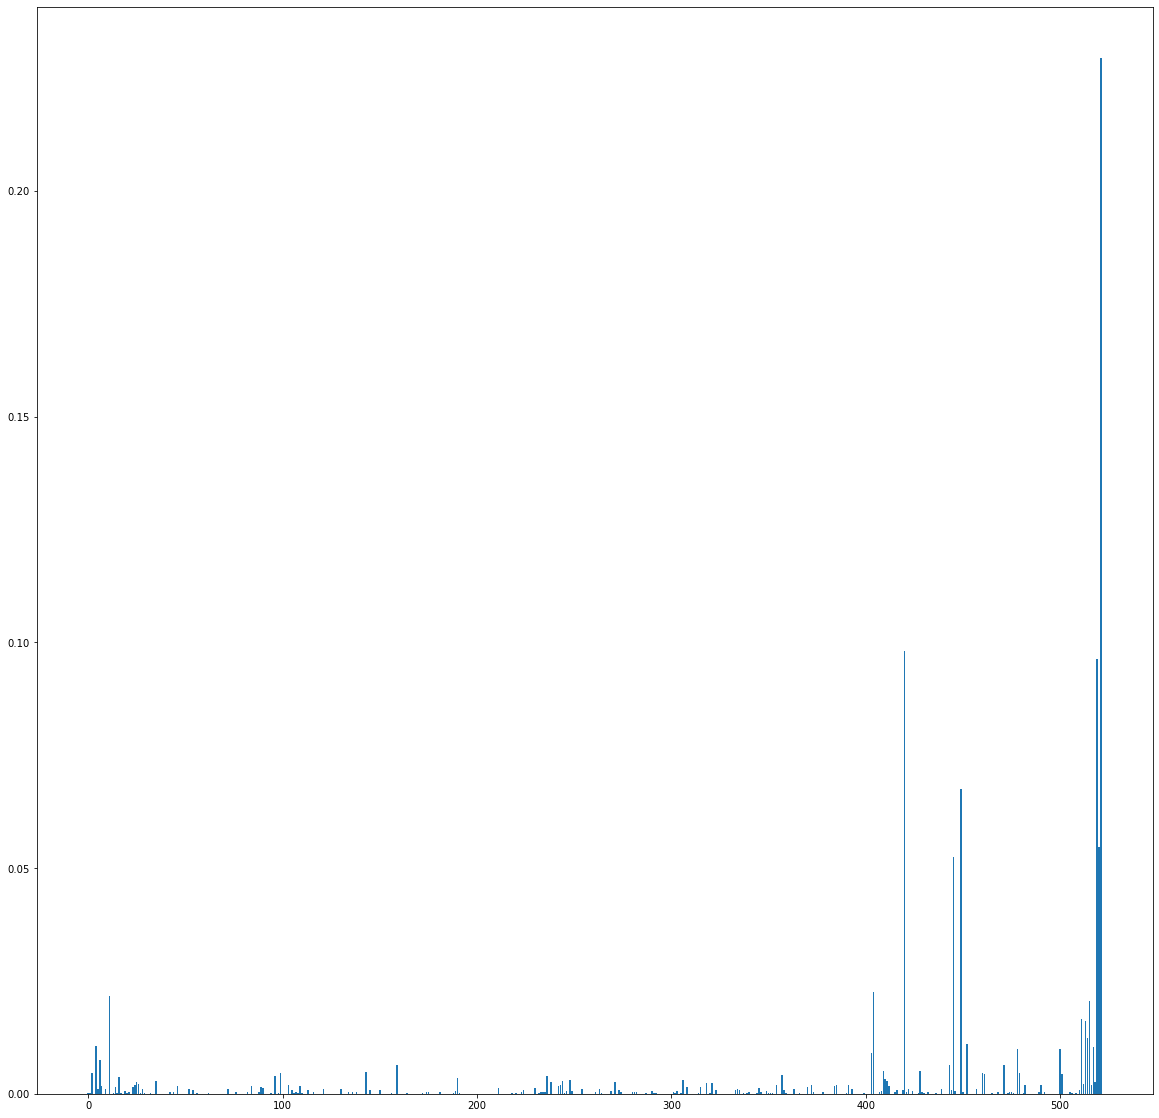

<Figure size 432x288 with 0 Axes>

In [32]:
importance = model_xgb.feature_importances_
nul_col = []
for i,v in enumerate(importance):
    if v == 0:
        nul_col.append(i)
nul_col_name = []
for i in nul_col:
    nul_col_name.append(col_name_lib[str(i)])
print(len(nul_col_name))

df_fi = {}
for i,v in enumerate(importance):
    x = col_name_lib[str(i)]
    df_fi[f'{x}'] = v

df_fi = pd.DataFrame(df_fi, index = ['Feature_Importance']).T
print(df_fi['Feature_Importance'].nlargest(10))


# plot feature importance
fig, ax = plt.subplots(figsize = (20,20))
ax.bar([x for x in range(len(importance))], importance)
plt.show()
plt.savefig('feat_imp_ergy.png', bbox_inches = 'tight')

In [47]:
df_year={}
df_tar = pd.DataFrame(ytest)
df_res = df_res.join(df_tar)
for i in df_res['YearBuilt'].unique():
    df_year[f'{i}'] = df_res[df_res['YearBuilt'] == i]
len(df_year)



99

In [ ]:
df_res.info()

In [146]:
def feature_error(df_lib,model,met,newcol=None):
    results = []
    for i in df_lib:
        x = df_lib[str(i)]
        if newcol:
            x = x.drop(axis = 1, labels = newcol)
        y = x['SiteEUI(kBtu/sf)']
        x = x.drop(axis = 1, labels = 'SiteEUI(kBtu/sf)')
        sqf = x['PropertyGFABuilding(s)']
        x = sscaler_fit.transform(x)
        
        y = np.array(np.log(y)).reshape(-1,1)     
        pred = model.predict(x)
        
        y = np.array(y).reshape(-1,1)
        pred = np.array(pred).reshape(-1,1)
        
        sqf = np.array(sqf).reshape(-1,1)
        y = y*sqf
        pred = pred*sqf
        
        if met == 'r2':
            line_reg_fit  = line_reg.fit(pred,y)
            results.append(line_reg_fit.score(pred,y))
        if met == 'nrmse':
            results.append(np.sqrt(metrics.mean_squared_error(y,pred))/np.mean(y))
        if met =='mae':
            results.append(np.sqrt(metrics.mean_absolute_error(y,pred)))
        
    return results
    

In [130]:
def prout(a, b=None):
    if b:
        print(b)
    print('prout2' + a)
    
prout('caca', 'pipi')

pipi
prout2caca


In [ ]:
pd.DataFrame(df_res_train['YearBuilt'].value_counts()).sort_values(by = 'YearBuilt').head(10)


1999.0    1324.402105
1945.0    1274.542333
2010.0    1233.969046
2005.0    1143.828032
1990.0    1090.268666
1976.0     999.548838
2015.0     893.974018
1958.0     866.642033
1995.0     802.986483
2008.0     778.200037
Name: NRMSE, dtype: float64


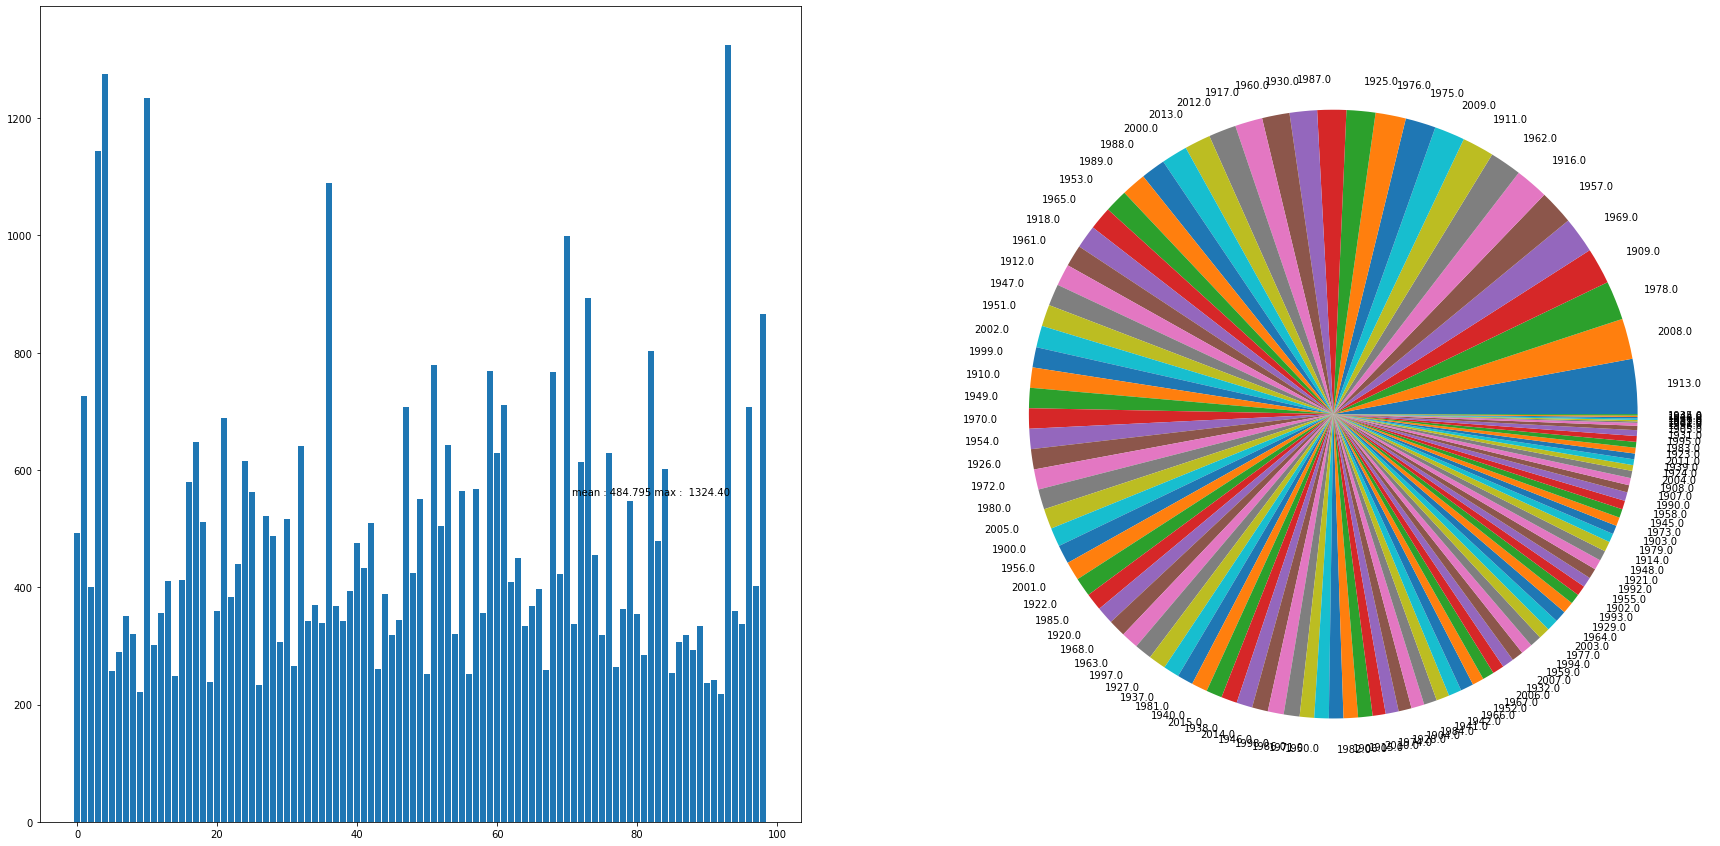

In [147]:
results = feature_error(df_year,model_xgb,'mae')

results_year = {}
for i,v in zip(df_year,results):
    results_year[f'{i}'] = v
    
results_year = pd.DataFrame(results_year, index = ['NRMSE']).T
print(results_year['NRMSE'].nlargest(10))

fig, ax = plt.subplots(1,2,figsize = (30,15))
ax[0].bar([x for x in range(len(results_year.index))],results_year['NRMSE'])
ax[0].text(0.7,0.4,'mean : {:.3f} max : {: .2f}'.format(results_year['NRMSE'].mean(), results_year['NRMSE'].max()), transform = ax[0].transAxes)
ax[1].pie(df_res_train['YearBuilt'].value_counts(), labels = df_res_train['YearBuilt'].unique())
plt.savefig('YearBuilt_ergy.png', bbox_inches = 'tight')
plt.show()

In [141]:
gfa_dis

0       (9412.728, 15807.2]
1       (15807.2, 459748.0]
2          (2548.0, 3167.0]
3          (6660.6, 7706.6]
4          (6660.6, 7706.6]
               ...         
1625       (-0.001, 2548.0]
1626       (3167.0, 3987.4]
1627       (-0.001, 2548.0]
1628       (-0.001, 2548.0]
1629       (-0.001, 2548.0]
Name: GFAdistribution, Length: 1630, dtype: category
Categories (10, interval[float64, right]): [(-0.001, 2548.0] < (2548.0, 3167.0] < (3167.0, 3987.4] < (3987.4, 4655.72] ... (6660.6, 7706.6] < (7706.6, 9412.728] < (9412.728, 15807.2] < (15807.2, 459748.0]]

2    372.508329
0    222.696239
6    198.276074
7    193.208366
9    179.074562
4    163.788270
3    159.898506
8    135.704949
1    112.629258
5    104.709756
Name: NRMSE, dtype: float64


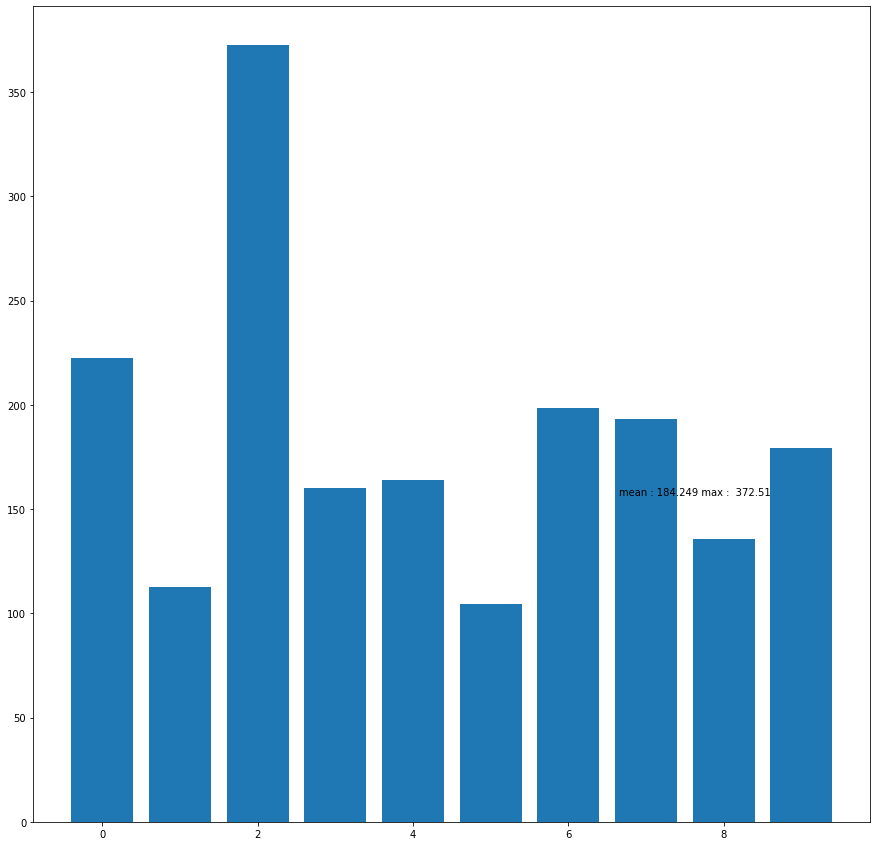

In [138]:
df_gfa = df
df_gfa['GFAdistribution'] = pd.qcut(df['ThirdLargestPropertyUseTypeGFA'],10, duplicates = 'drop')
target = df_gfa[target_tag]
sqf = df_gfa['PropertyGFABuilding(s)']
gfa_dis = df_gfa['GFAdistribution']
df_gfa = df_gfa.drop(labels = [target_tag,'GFAdistribution', 'TotalGHGEmissions', 'ENERGYSTARScore','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity'], axis = 1)

xtrain, xtest, ytrain, ytest, sqftrain, sqftest, distrain, distest = train_test_split(df_gfa, target, sqf, gfa_dis, test_size = 0.2, random_state = rand)
df_gfa_res = xtest
df_gfa_res = df_gfa_res.join(pd.DataFrame(distest))
df_gfa_res = df_gfa_res.join(pd.DataFrame(ytest))


df_gfa_lib = {}
for i,v in enumerate(df_gfa_res['GFAdistribution'].unique()):
    df_gfa_lib[f'{i}'] = df_gfa_res[df_gfa_res['GFAdistribution'] == v]

results = feature_error(df_gfa_lib,model_xgb,'mae',newcol = 'GFAdistribution')

results_gfa = {}
for i,v in zip(df_gfa_lib,results):
    results_gfa[f'{str(i)}'] = v
    
results_gfa = pd.DataFrame(results_gfa, index = ['NRMSE']).T
print(results_gfa['NRMSE'].nlargest(10))

fig, ax = plt.subplots(figsize = (15,15))
ax.bar([x for x in range(len(results_gfa.index))],results_gfa['NRMSE'])
ax.text(0.7,0.4,'mean : {:.3f} max : {: .2f}'.format(results_gfa['NRMSE'].mean(), results_gfa['NRMSE'].max()), transform = ax.transAxes)
plt.savefig('ThirdGFAanalysis.png', bbox_inches = 'tight')
plt.show()

7    265.545587
5    258.868028
1    211.446904
9    204.419919
0    203.598748
2    197.564239
3    183.635004
8    180.191515
6    164.990106
4    153.244866
Name: NRMSE, dtype: float64


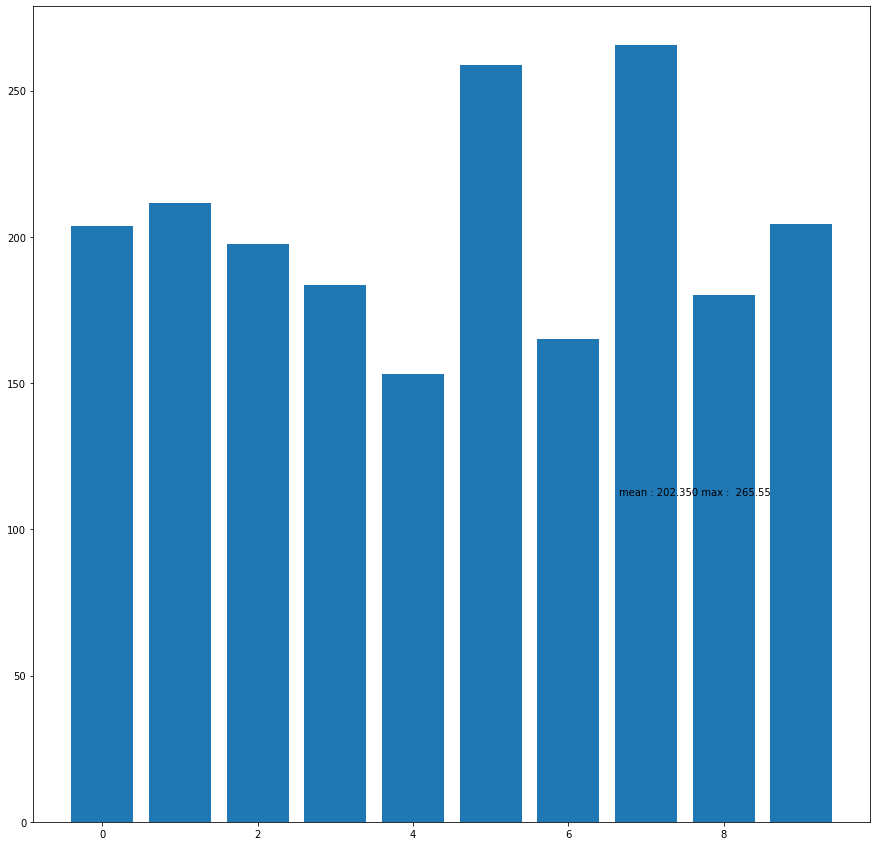

In [145]:
df_tar = df
df_tar['Ydistribution'] = pd.qcut(df[target_tag],10, duplicates = 'drop')
target = df_tar[target_tag]
sqf = df_tar['PropertyGFABuilding(s)']
dis = df_tar['Ydistribution']
df_tar = df_tar.drop(labels = [target_tag,'Ydistribution','TotalGHGEmissions', 'ENERGYSTARScore','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity'], axis = 1)

xtrain, xtest, ytrain, ytest, sqftrain, sqftest,distrain,distest = train_test_split(df_gfa, target, sqf,dis, test_size = 0.2, random_state = rand)
df_tar_res = xtest
df_tar_res = df_tar_res.join(pd.DataFrame(dis))
df_tar_res = df_tar_res.join(pd.DataFrame(ytest))


df_tar_lib = {}
for i,v in enumerate(df_tar_res['Ydistribution'].unique()):
    df_tar_lib[f'{i}'] = df_tar_res[df_tar_res['Ydistribution'] == v]

results = feature_error(df_tar_lib,model_xgb,'mae',newcol = 'Ydistribution')

results_tar = {}
for i,v in zip(df_tar_lib,results):
    results_tar[f'{str(i)}'] = v
    
results_tar = pd.DataFrame(results_tar, index = ['NRMSE']).T
print(results_tar['NRMSE'].nlargest(10))

fig, ax = plt.subplots(figsize = (15,15))
ax.bar([x for x in range(len(results_tar.index))],results_tar['NRMSE'])
ax.text(0.7,0.4,'mean : {:.3f} max : {: .2f}'.format(results_tar['NRMSE'].mean(), results_tar['NRMSE'].max()), transform = ax.transAxes)
plt.savefig('TargetAanalysis.png', bbox_inches = 'tight')
plt.show()

### Etude de l'impact de l'Energy Score

In [ ]:

data_num = df
target_tag = 'SiteEUI(kBtu/sf)'
target = data_num[target_tag]
label = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity']
sqf = data_num['PropertyGFABuilding(s)']
data_num = data_num.drop(labels = [target_tag, 'TotalGHGEmissions','SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity'], axis = 1)

#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest, sqftrain, sqftest = train_test_split(data_num, target, sqf, test_size = 0.2)

df_res = xtrain

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)

sqftrain = np.array(sqftrain).reshape(-1,1)
sqftest = np.array(sqftest).reshape(-1,1)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 120 candidates, totalling 360 fits
Fitting 3 folds for each of 360 candidates, totalling 1080 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.95711e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=5.29824e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.15981e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.29378e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.p

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 523       
                                                                 
Total params: 523
Trainable params: 523
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 1s 860us/step - loss: 118.9847 - root_mean_squared_error: 8.7038
Epoch 2/50
1304/1304 [==============================] - 1s 854us/step - loss: 92.6278 - root_mean_squared_error: 7.7494
Epoch 3/50
1304/1304 [==============================] - 1s 880us/step - loss: 82.6585 - root_mean_squared_error: 7.1600
Epoch 4/50
1304/1304 [==============================] - 1s 889us/step - loss: 74.0837 - root_mean_squared_error: 6.5864
Epoch 5/50
1304/1304 [==============================] - 1s 831us/step - loss: 66.7716 - root_mean_squar

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    7.5s finished


Fitting 3 folds for each of 10 candidates, totalling 30 fits
11/11 [==============================] - 0s 2ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


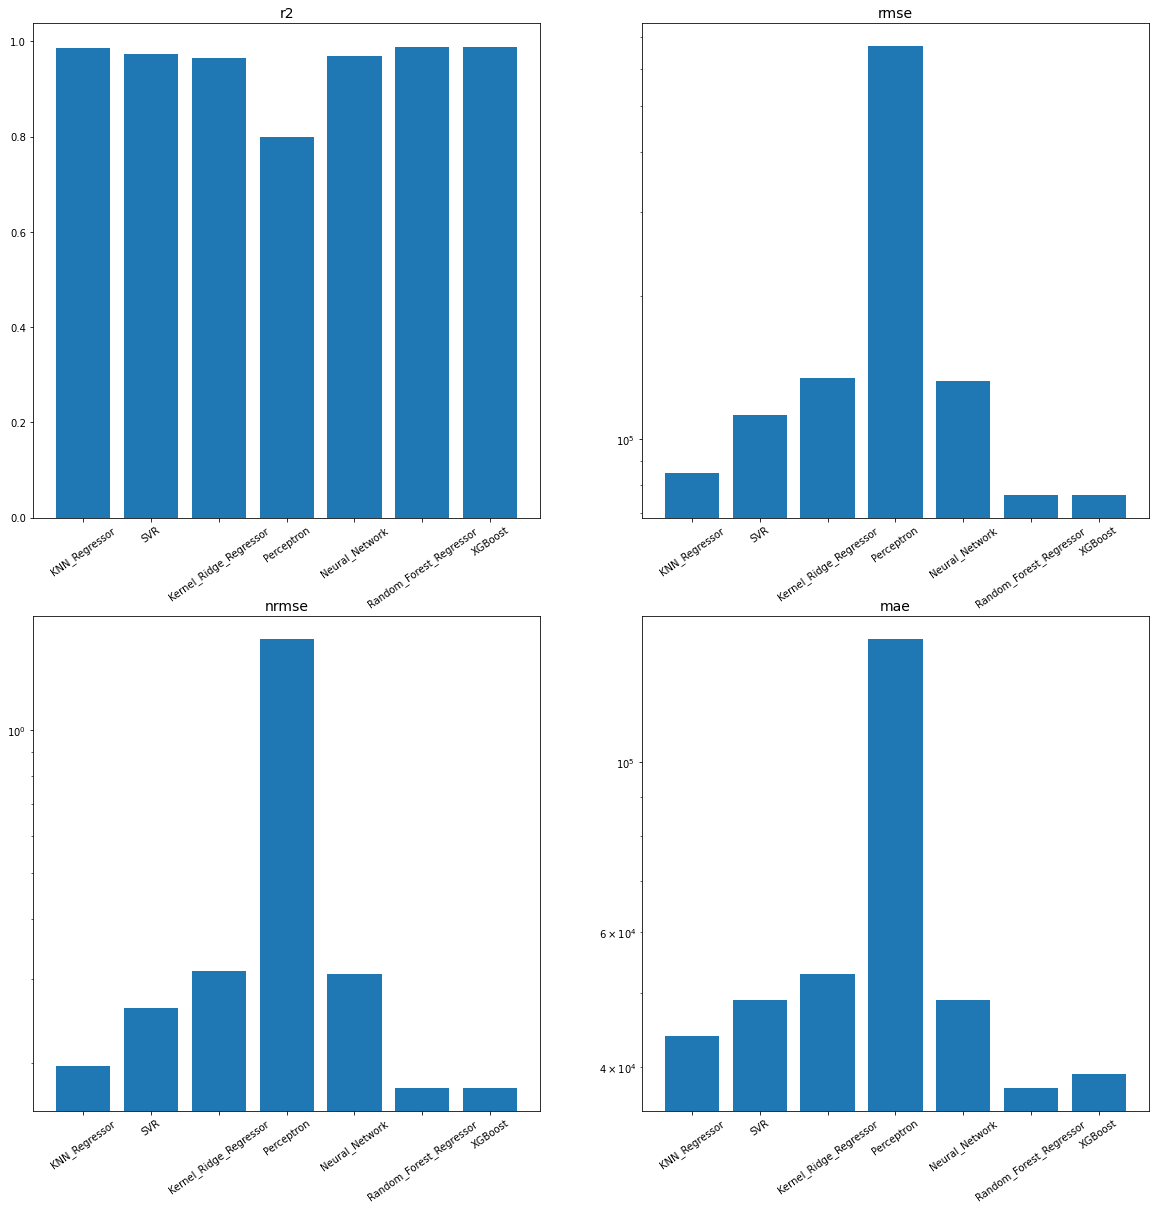

In [33]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)
    
model_kn2 = KNeighborsRegressor(n_neighbors = reg.best_params_['n_neighbors']).fit(xtrain, ytrain)

 #let's try with a svr
C_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
degrees = [2,3,4]
gamma_range  = np.logspace(-2, 1, 10)

param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

score = 'neg_mean_squared_error'

svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

svr_cv.fit(xtrain, ytrain)


bkernel = svr_cv.best_params_['kernel']
bgamma = svr_cv.best_params_['gamma']
bdegree = svr_cv.best_params_['degree']
    
svr = svm.SVR(kernel=bkernel, C=1.0, gamma = bgamma, degree = bdegree)
model_svr2 = svr.fit(xtrain,ytrain)


#kernel ridge
alpha_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'poly', 'rbf']
degrees = [3,4,5]
gamma_range  = np.logspace(-2, 1, 10)


param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}
    
score = 'neg_mean_absolute_percentage_error'

kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

kernel_ridge_cv.fit(xtrain, ytrain)
    
bkernel = kernel_ridge_cv.best_params_['kernel']
bgamma = kernel_ridge_cv.best_params_['gamma']
bdegree = kernel_ridge_cv.best_params_['degree']
balpha = kernel_ridge_cv.best_params_['alpha']

model = kernel_ridge.KernelRidge(alpha = balpha, kernel = bkernel, degree = bdegree, gamma = bgamma)
model_krr2 = model.fit(xtrain, ytrain)

#test with a single perceptron
model1_2 = keras.Sequential()
model1_2.add(keras.Input(shape = xtrain.shape[1]))
model1_2.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1_2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1_2.summary()

history1 = model1_2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

# neural network

model3_2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="selu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(383, activation="selu", name="layer2a"),
        layers.Dense(287, activation="selu", name="layer2"),
        layers.Dense(82, activation="selu", name="layer3"),
        layers.Dense(20, activation="selu", name="layer4"),
        layers.Dense(1, activation = 'linear', name="layer6"),
    ]
)

model3_2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3_2.summary()

history3 = model3_2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

#random forest

n_grid = {'n_estimators' : list(np.arange(50,550,50))}
score = 'r2'

rfr_grid = GridSearchCV(RandomForestRegressor(), n_grid, cv =3, scoring = score, verbose = 1)

rfr_grid.fit(xtrain, ytrain)
    
model_rfr2 = RandomForestRegressor(n_estimators=rfr_grid.best_params_['n_estimators'], verbose = 1).fit(xtrain, ytrain)

#xgBoost

n_grid = {'n_estimators' : list(np.arange(50,550,50))}
score = 'r2'

xgb_grid = GridSearchCV(GradientBoostingRegressor(), n_grid, cv =3, scoring = score, verbose = 1)

xgb_grid.fit(xtrain, ytrain)
    
model_xgb2 = GradientBoostingRegressor(n_estimators=xgb_grid.best_params_['n_estimators']).fit(xtrain, ytrain)



11/11 [==============================] - 0s 2ms/step


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    0.0s finished


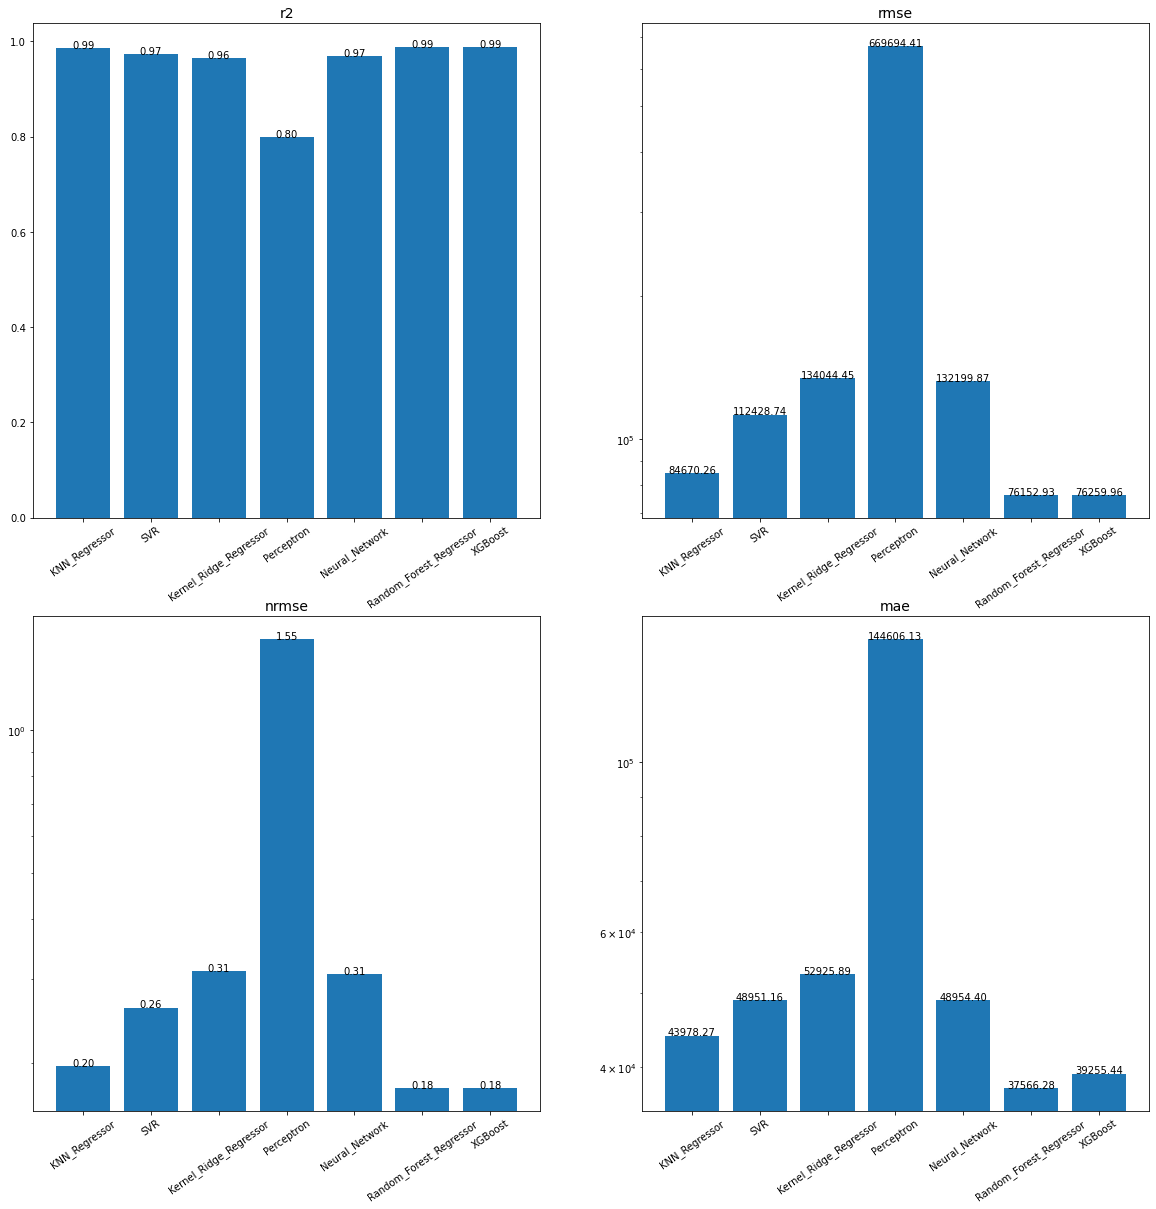

In [44]:
#plot the metrics

metrics_all = {}

models = [model_kn2,model_svr2,model_krr2,model1_2,model3_2,model_rfr2,model_xgb2]
r2l=[]
rmsel=[]
nrmsel=[]
mael=[]

for i in models:
    r2l.append(r2(i.predict(xtest),ytest))
    rmsel.append(rmse(i.predict(xtest), ytest))
    nrmsel.append(nrmse(i.predict(xtest), ytest))
    mael.append(mae(i.predict(xtest), ytest))
    
metrics_all['r2'] = r2l
metrics_all['rmse'] = rmsel
metrics_all['nrmse'] = nrmsel
metrics_all['mae'] = mael

model_names = ['KNN_Regressor', 'SVR', 'Kernel_Ridge_Regressor','Perceptron','Neural_Network', 'Random_Forest_Regressor', 'XGBoost']
df_metrics = pd.DataFrame(metrics_all, index = model_names)

fig = plt.figure(figsize=(20, 20))
for i in range(df_metrics.shape[1]):
    ax = fig.add_subplot(2,2, (i+1))
    b = ax.bar(x=df_metrics.index,height = df_metrics.iloc[:, i])
    for y,v in enumerate(df_metrics.iloc[:, i]):
        ax.text(y,v, '%.2f'%v, ha = 'center')
    ax.set_title(df_metrics.columns[i], fontsize=14)
    ax.tick_params(axis='x', labelrotation = 35)
    if i != 0:
        ax.set_yscale('log')
        
plt.savefig('recap_ergy_ess.png', bbox_inches = 'tight')


285
ThirdLargestPropertyUseTypeGFA                       0.229103
LargestPropertyUseType_Non-Refrigerated Warehouse    0.098075
PropertyGFABuilding(s)                               0.095830
LargestPropertyUseType_Supermarket/Grocery Store     0.067597
SecondLargestPropertyUseTypeGFA                      0.057023
LargestPropertyUseType_Self-Storage Facility         0.052480
LargestPropertyUseType_Distribution Center           0.023013
PrimaryPropertyType_Other                            0.021651
YearBuilt                                            0.018964
Latitude                                             0.016694
Name: Feature_Importance, dtype: float64


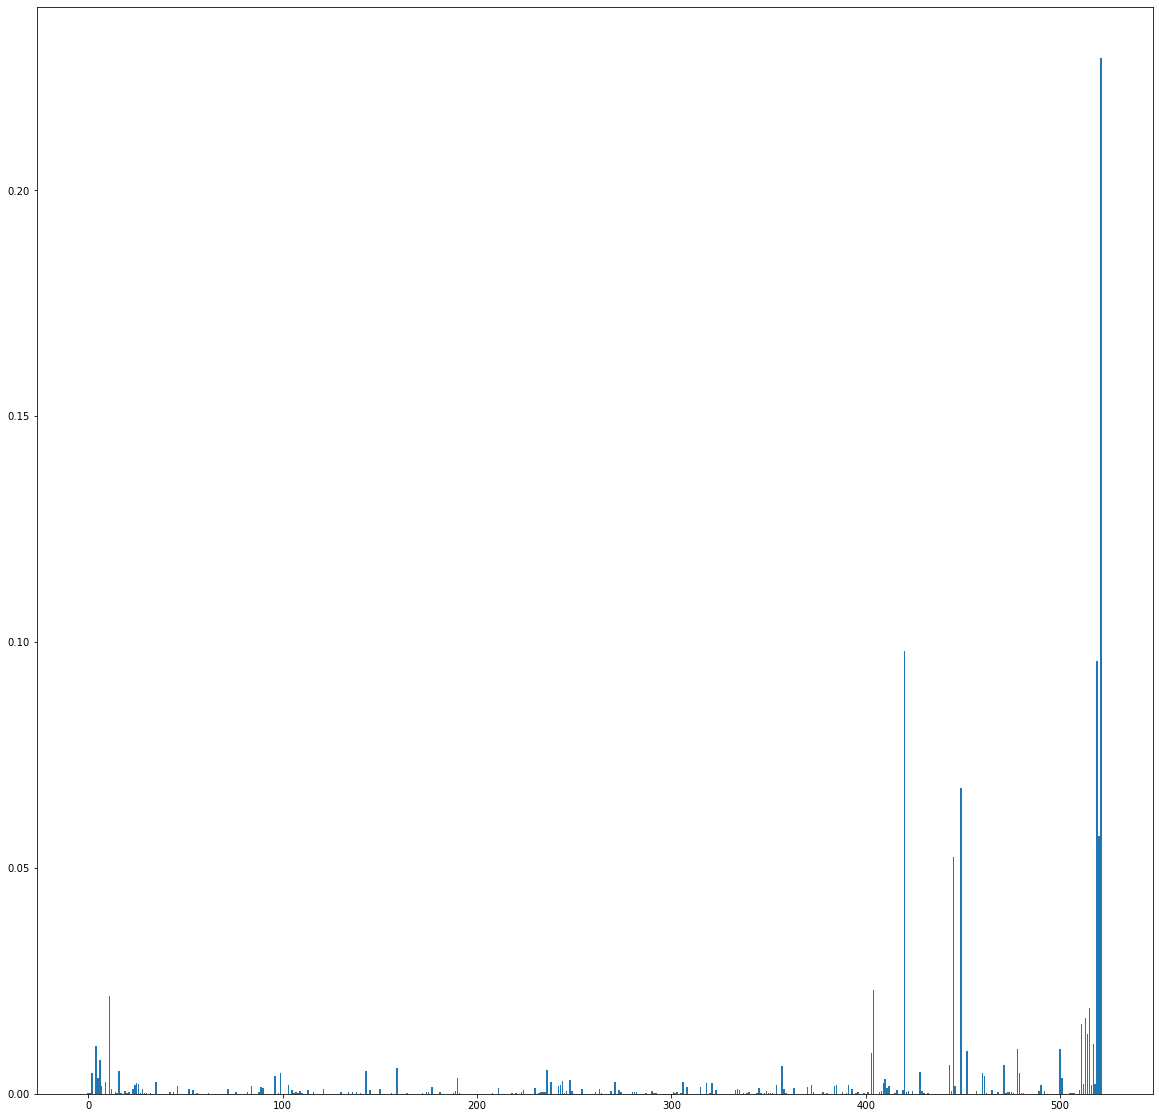

<Figure size 432x288 with 0 Axes>

In [46]:
importance = model_xgb2.feature_importances_
nul_col = []
for i,v in enumerate(importance):
    if v == 0:
        nul_col.append(i)
nul_col_name = []
for i in nul_col:
    nul_col_name.append(col_name_lib[str(i)])
print(len(nul_col_name))

df_fi = {}
for i,v in enumerate(importance):
    x = col_name_lib[str(i)]
    df_fi[f'{x}'] = v

df_fi = pd.DataFrame(df_fi, index = ['Feature_Importance']).T
print(df_fi['Feature_Importance'].nlargest(10))


# plot feature importance
fig, ax = plt.subplots(figsize = (20,20))
ax.bar([x for x in range(len(importance))], importance)
plt.show()
plt.savefig('feat_imp_ergy_ess.png', bbox_inches = 'tight')